In [103]:
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(rc={'figure.figsize':(8, 6)})

In [104]:
def analize_dataframe(df: pd.DataFrame):
    print(df.head(3), '\n')
    print(df.info(), '\n')
    print(f'Пропуски:\n{df.isna().sum()}\n')
    print(df.describe())

    num_cols = []
    cat_cols = []
    bool_cols = []
    date_cols = []
    for col in df.columns:
        if df[col].dtype == 'object':
            cat_cols.append(col)
            print(f'\nКатегориальный столбец: {df[col].name}')
            print(df[col].value_counts())
        elif df[col].dtype in ['int64', 'float64']:
            num_cols.append(col)
        elif df[col].dtype == 'bool':
            bool_cols.append(col)
        elif df[col].dtype == 'datetime64[ns]':
            date_cols.append(col)            

    return (num_cols, cat_cols, bool_cols, date_cols)

In [105]:
user = pd.read_csv('datasets/sirius/food_shop/user.csv')
userab = pd.read_csv('datasets/sirius/food_shop/user_ab_group.csv')
user_purch = pd.read_csv('datasets/sirius/food_shop/user_purchase.csv')
user_purch['date_time'] = pd.to_datetime(user_purch['date_time'], format='%Y-%m-%d %H:%M:%S')
good = pd.read_csv('datasets/sirius/food_shop/good.csv')
good_purch = pd.read_csv('datasets/sirius/food_shop/purchase_good.csv')

In [106]:
user_treatment = userab[userab.group == 'treatment']['user_id']
user_control = userab[userab.group == 'control']['user_id']
len(user_treatment), len(user_control), len(user)

(5990, 5925, 15000)

Данные в предоставленных таблицах не требуют дополнительной очистки. 

Пользователи, участвствующие в тестировании, разбиты на две примерно равные группы:
- в тестовой группе: **5990** человек,
- в контрольной группе: **5925** человек.

Итого приняли участие в эксперименте **11915** пользователей из **15000**.

In [107]:
user_purch = user_purch[(user_purch.date_time.dt.month == 10) & (user_purch.date_time.dt.day <= 14)]

In [108]:
print(user_purch[user_purch['user_id'].isin(user_control)]['date_time'].describe()[['min', 'max']])
print(user_purch[user_purch['user_id'].isin(user_treatment)]['date_time'].describe()[['min', 'max']])

min    2023-10-01 00:02:46
max    2023-10-14 23:55:09
Name: date_time, dtype: object
min    2023-10-01 00:02:30
max    2023-10-14 23:58:28
Name: date_time, dtype: object


In [109]:
print(user_purch[user_purch['user_id'].isin(user_treatment)].count()['id'])
print(user_purch[user_purch['user_id'].isin(user_control)].count()['id'])

5879
5944


Время проведения эксперимента: **с 1 по 14 октября 2023 года** включительно.

За время проведения эксперимента получены данные о покупках **5879** тестируемой и **5944** контрольной групп.

In [133]:
purchases = good_purch \
    .merge(good, left_on='good_id', right_on='id') \
    .drop(columns='id') \
    .merge(user_purch, left_on='purchase_id', right_on='id') \
    .rename(columns={'was_in_recommended_goods': 'recommended', 'good_name': 'good', 'price_per_unit': 'price'}) \
    .assign(ad_price = lambda p: p['amount'] * p['price'] * p['recommended']) \
    .assign(total_price = lambda p: p['amount'] * p['price']) \
    .reindex(columns=['purchase_id', 'user_id', 'date_time', 'recommended', 'good', 'good_id', 'price', 'amount', 'ad_price', 'total_price']) \
    .sort_values('purchase_id')
# ad_price - купленые товары, предложенные рекомендательной системой
# total_price - все купленные товары

purchases[purchases.purchase_id == 1] # детализированный чек покупки #1
purchases[purchases.user_id == 7] # покупки пользователя #1

,purchase_id,user_id,date_time,recommended,good,good_id,price,amount,ad_price,total_price
27764,15945,7,2023-10-04 21:01:03,True,Семена чиа в желе,35,618,1,618,618
27765,15945,7,2023-10-04 21:01:03,True,Мука тигровых орехов,76,452,1,452,452
27766,15945,7,2023-10-04 21:01:03,True,Кунжутное масло,40,457,1,457,457
27767,15945,7,2023-10-04 21:01:03,False,Морская капуста сушёная,30,442,1,0,442


Создадим сводную таблицу покупок *purchases*, содержащую в себе все неоходимые данные для наших расчётов.

In [143]:
purchases_sum = purchases \
    .groupby(by=['purchase_id', 'user_id'], as_index=False) \
    .agg({'ad_price': 'sum', 'total_price': 'sum'}) \
    .assign(ad_frac = lambda p: round(p['ad_price'] / p['total_price'], 2))

print(f'Итого совершено покупок: {len(purchases_sum)}\n')
# print(purchases_sum.loc[0]) # покупка loc+1
purchases_sum[purchases_sum.user_id == 55] # покупки пользователя #

Итого совершено покупок: 14890



,purchase_id,user_id,ad_price,total_price,ad_frac
2446,14278,55,0,442,0.00
10736,22568,55,450,3021,0.15


Создадим таблицу *purchases_sum*, содержащую:
- стоимость товаров, купленных по рекомендации
- общую сумма чека
- долю рекомендательной суммы от полной суммы чека

Всего у нас имеются данные о **14890** покупке за время действия тестирования. 

In [112]:
user_purchases_sum = purchases_sum \
    .groupby(by=['user_id'], as_index=False) \
    .agg({'purchase_id': 'count', 'ad_price': 'sum', 'total_price': 'sum',  }) \
    .rename(columns={'purchase_id': 'n_buys'}) \
    .assign(ad_frac = lambda p: round(p['ad_price'] / p['total_price'], 2))

print(f'Итого пользователей, совершавших покупки: {len(user_purchases_sum)}\n')
user_purchases_sum[user_purchases_sum['user_id'] == 1]

Итого пользователей, совершавших покупки: 10788



,user_id,n_buys,ad_price,total_price,ad_frac
0,1,1,0,928,0.0


Создадим таблицу *user_purchases_sum*, содержащую аггрегированную информацию о всех покупках пользователя:

- стоимость товаров, купленных по рекомендации (для всех покупок пользователя)
- общую сумма чека (для всех покупок пользователя)
- долю рекомендательной суммы от полной суммы чека

Всего у нас имеются данные о **10788** из известных **15000** пользователей.

4309 4269


<Axes: >

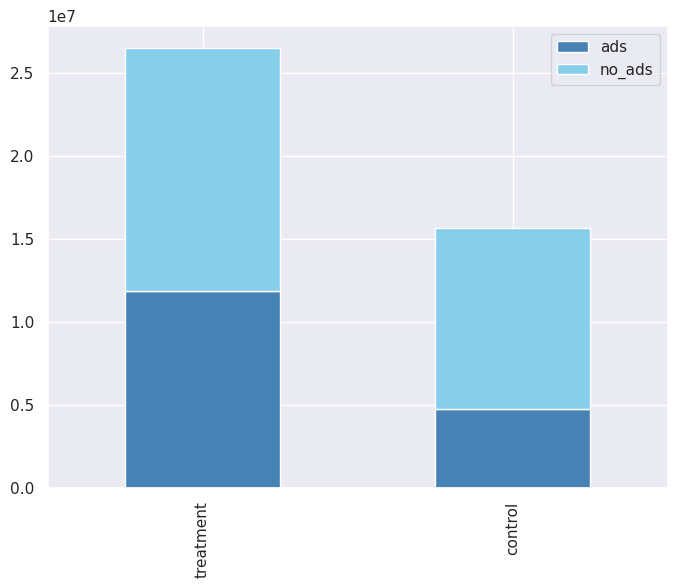

In [113]:
print(len(user_purchases_sum[user_purchases_sum.user_id.isin(user_treatment)]), \
len(user_purchases_sum[user_purchases_sum.user_id.isin(user_control)])) 

treatment_purchases = user_purchases_sum[user_purchases_sum.user_id.isin(user_treatment)].sum()
control_purchases = user_purchases_sum[user_purchases_sum.user_id.isin(user_control)].sum()

total_spends = pd.DataFrame(data=[
    [int(treatment_purchases.n_buys), int(control_purchases.n_buys)], 
    [int(treatment_purchases.ad_price), int(control_purchases.ad_price)],
    [int(treatment_purchases.total_price), int(control_purchases.total_price)], 
], index=['n_buys', 'ads', 'total'], columns=['treatment', 'control']).T
total_spends = total_spends \
    .assign(no_ads = lambda p: p['total'] - p['ads']) \
    .assign(ads_frac = lambda p: round(p['ads'] / p['total'], 3)) \
    .reindex(columns=['n_buys', 'ads', 'no_ads', 'total', 'ads_frac']) 

total_spends \
    .drop(columns=['n_buys', 'total', 'ads_frac']) \
    .plot(kind='bar', stacked=True, color=['steelblue', 'skyblue'])

In [127]:
summary = total_spends \
    .assign(mean_check = lambda p: round(p['total'] / p['n_buys'], 2)) \
    .assign(users = [
        len(user_purchases_sum[user_purchases_sum.user_id.isin(user_treatment)]),
        len(user_purchases_sum[user_purchases_sum.user_id.isin(user_control)])]) \
    .assign(revenue_by_user = lambda p: round(p['total'] / p['users'], 2))

summary

,n_buys,ads,no_ads,total,ads_frac,mean_check,users,revenue_by_user
treatment,5879,11855115,14663220,26518335,0.447,4510.69,4309,6154.17
control,5944,4738958,10921525,15660483,0.303,2634.67,4269,3668.42


Из **5990** человек тестовой группы совершили покупк в тестовый период: **4309** человек.

Всего тестовой группой совершено **5879** покупок, на сумму **26 518 335**руб., из которых **11 855 115**руб. на товары предложенные рекомендательной системой (что составляет долю **0.447**). На товары, которые не были рекомендованы системой, было потрачено **14 663 220**руб.


Из **5925** человек контрольной группы совершили покупки в тестовый период: **4269** человек.

Всего контрольной группой совершено **5944** покупок, на сумму **15 660 483**руб., из которых **4 738 958**руб. на товары предложенные рекомендательной системой (что составляет долю **0.303**). На товары, которые не были рекомендованы системой, было потрачено **10 921 525**руб.

Тестовая группа проказала итоговое увеличение выручки за тестовый период на **10 857 852**руб., из которых **7 116 157**руб. за счёт продажи рекомендованных товаров.

Средний чек в тестовой группе составил: **4510**руб. (**+71%**)

Средний чек в контройльной группе составил: **2634**руб.

> придумать метрику для сравнения двух групп, которая будет являться средним в некоторой выборке значений

Нашей метрикой будет средняя выручка на пользователя.

В тестовой группе средняя выручка на пользователя: **6154**руб. (**+68%**)

В контрольной группе средняя выручка на пользователя: **3668**руб.

In [156]:
from scipy.stats import ttest_ind

# создаём списки трат пользователей за тестовый период, по группам
treatment_revenue = list(user_purchases_sum[user_purchases_sum.user_id.isin(user_treatment)].total_price)
control_revenue = list(user_purchases_sum[user_purchases_sum.user_id.isin(user_control)].total_price)

# дополняем списки трат нулевыми значениями, отражающими пользователей из групп, не сделавних ни одной покупки
treatment_revenue_z = treatment_revenue + [0] * (len(user_treatment) - len(treatmen_revenue))
control_revenue_z = control_revenue + [0] * (len(user_control) - len(control_revenue))

tt_result = ttest_ind(treatment_revenue_z, control_revenue_z, equal_var=False)
tt_result

TtestResult(statistic=24.233967540582896, pvalue=3.363478798853414e-126, df=10232.906892414547)

/home/azor/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/azor/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

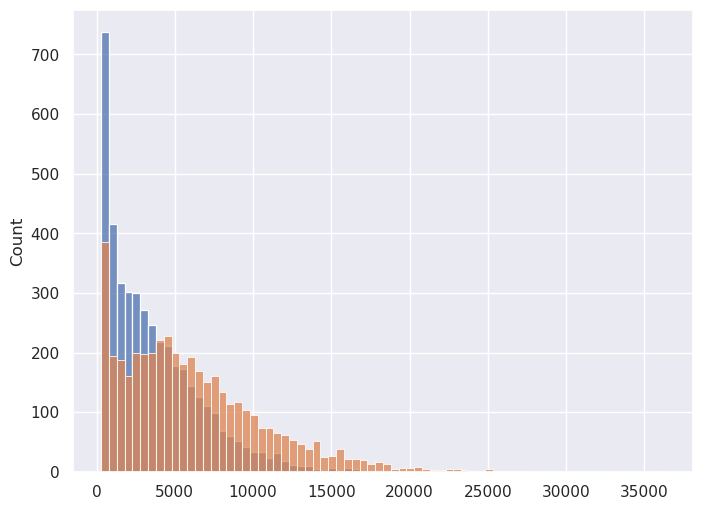

In [155]:
sns.histplot(control_revenue, binwidth=500)
sns.histplot(treatment_revenue, binwidth=500)

In [157]:
tt_result[1]

3.363478798853414e-126

ТТест подверждает сделанные нами ранее наблюдения о статистически значимых отличиях средней выручки на пользователя.

In [158]:
user_purchases_sum

,user_id,n_buys,ad_price,total_price,ad_frac
0,1,1,0,928,0.00
1,2,1,4481,7190,0.62
2,4,1,0,447,0.00
3,5,1,513,1097,0.47
4,6,1,665,665,1.00
...,...,...,...,...,...
10783,14994,1,964,2586,0.37
10784,14996,3,3977,6996,0.57
10785,14997,2,2038,12832,0.16
10786,14998,1,4536,6498,0.70


In [167]:
user_purchases_sum[user_purchases_sum.user_id.isin(user_treatment)].mean()['n_buys']

1.3643536783476444

In [168]:
user_purchases_sum[user_purchases_sum.user_id.isin(user_control)].mean()['n_buys']

1.3923635511829469